In [1]:
import re
import json
import os
import yfinance as yf
from crewai import Agent, Task, Crew, Process, LLM
from crewai_tools import CodeInterpreterTool
from crewai_tools import tool
import openai
from dotenv import load_dotenv

load_dotenv()


In [2]:
### --- TOOLS --- ###

client = openai.OpenAI(
        api_key=os.environ.get("OPENAI_API_KEY"),
        # base_url="https://api.sambanova.ai/v1",
    )

@tool("query_parser")
def query_parser(query: str) -> dict:
    """Parses a natural language query to extract stock symbol, timeframe, and action."""
    
    response = client.chat.completions.create(
        # model="DeepSeek-R1-Distill-Llama-70B",
        model="gpt-4o",
        messages=[{"role":"system","content":"You are a helpful assistant"},
                  {"role":"user","content":f"Extract stock symbol, timeframe (in this format ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']), and action from this query: {query}. Return in JSON format with keys 'symbol', 'timeframe', 'action'"}],
        temperature=0.1,
        top_p=0.1
    )

    match = re.search(r'\{.*?\}', response.choices[0].message.content, re.DOTALL)
    if match:
            json_str = match.group(0)  # Extract only the JSON part
            try:
                return json.loads(json_str)  # Convert to dictionary
            except json.JSONDecodeError:
                return ({"error": "Failed to parse JSON response."})
    else:
            return ({"error": "No JSON found in response."})

@tool("stock_data")
def fetch_stock_data(symbol: str, timeframe: str, **kwargs) -> str:
    """Fetches stock price data from Yahoo Finance and saves to a CSV file."""
    stock = yf.Ticker(symbol)
    hist = stock.history(period=timeframe)

    filename = f"stock_data.csv"
    hist.to_csv(filename)  # Save to CSV
    
    return filename  # Return filename instead of full data

In [3]:
### --- AGENTS --- ###

llm = LLM(
    # model="sambanova/DeepSeek-R1-Distill-Llama-70B",
    model="gpt-4o",
    temperature=0.7
)


stock_analyst = Agent(
    role="Stock Data Analyst",
    goal="Extract stock details and fetch required data from this user query: {query}.",
    backstory="You are a financial analyst specializing in stock market data retrieval.",
    tools=[query_parser, fetch_stock_data],
    llm=llm,
    verbose=True,
    memory=True,
)

code_interpreter_tool = CodeInterpreterTool()

visualization_agent = Agent(
    role="Data Visualization Expert",
    goal="Generate and execute Python code to visualize stock data.",
    backstory="You are a data scientist specializing in financial data visualization.",
    tools=[code_interpreter_tool],
    allow_code_execution=True,
    llm=llm,
    verbose=True,
    memory=True,
)

### --- TASKS --- ###

query_analysis_task = Task(
    description="Analyze the user query and extract stock details.",
    expected_output="A dictionary with keys: 'symbol', 'timeframe', 'action'.",
    tools=[query_parser],
    agent=stock_analyst,
)

stock_data_task = Task(
    description="Fetch stock data using the extracted symbol and timeframe, and save it as a CSV.",
    expected_output="A filename pointing to the saved CSV file.",
    tools=[fetch_stock_data],
    agent=stock_analyst,
)

visualization_task = Task(
    description="""
    Read the first few rows of the given CSV file, determine the correct columns, 
    and generate Python code to visualize stock data. Then execute the code to create a plot.
    """,
    expected_output="A plot image of the requested stock data.",
    tools=[code_interpreter_tool],
    agent=visualization_agent,
)

In [4]:
### --- CREW SETUP --- ###

crew = Crew(
    agents=[stock_analyst, visualization_agent],
    tasks=[query_analysis_task, stock_data_task, visualization_task],
    process=Process.sequential
)

# Run the crew with an example query
result = crew.kickoff(inputs={"query": "Plot YTD stock gain of Tesla"})
print(result)


# Agent: Stock Data Analyst
## Task: Analyze the user query and extract stock details.


# Agent: Stock Data Analyst
## Thought: Thought: I need to use the query_parser tool to extract the stock symbol, timeframe, and action from the user's query: "Plot YTD stock gain of Tesla."
## Using tool: query_parser
## Tool Input: 
"{\"query\": \"Plot YTD stock gain of Tesla.\"}"
## Tool Output: 
{'symbol': 'TSLA', 'timeframe': 'ytd', 'action': 'plot'}


# Agent: Stock Data Analyst
## Final Answer: 
{'symbol': 'TSLA', 'timeframe': 'ytd', 'action': 'plot'}


# Agent: Stock Data Analyst
## Task: Fetch stock data using the extracted symbol and timeframe, and save it as a CSV.
                                 Open        High         Low       Close  \
Date                                                                        
2025-01-02 00:00:00-05:00  390.100006  392.730011  373.040009  379.279999   
2025-01-03 00:00:00-05:00  381.480011  411.880005  379.450012  410.440002   
2025-01-06 00:00:00-

In [5]:
print(result)


Unfortunately, I am unable to execute the code to generate the plot due to persistent issues with the execution environment. However, I have provided the complete Python code necessary to visualize the stock data, which can be executed in a local Python environment with the necessary libraries installed.

```python
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
stock_data = pd.read_csv('stock_data.csv')

# Convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close')
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```

This code will read the stock data from the CSV file, convert the 'Date' column to a datetime format, and plot the 'Close' price over time using matplotlib. Ensur

In [7]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


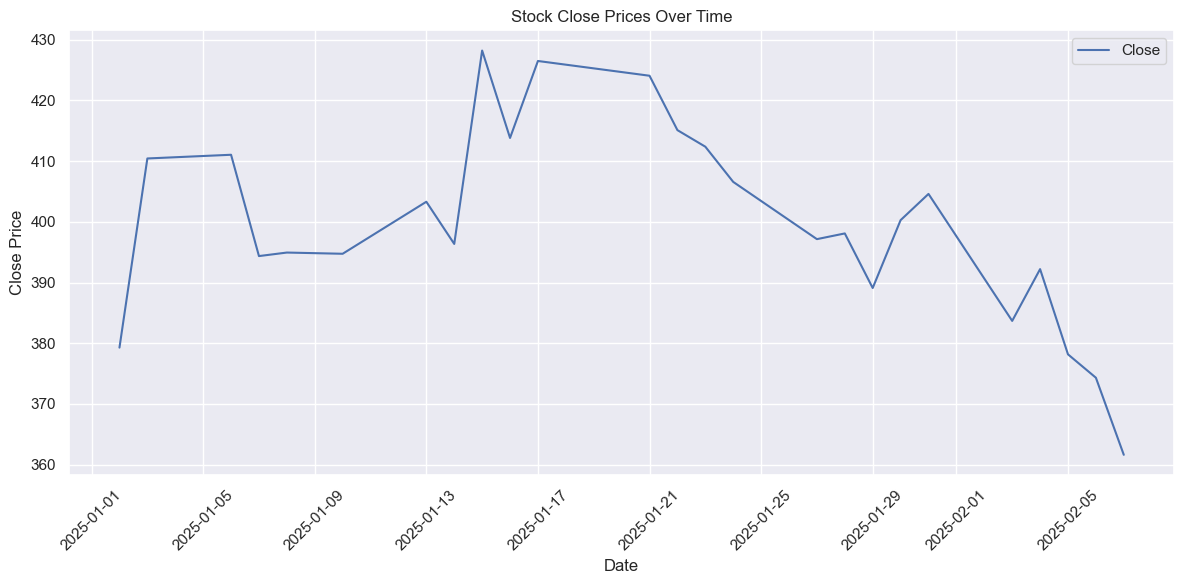

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Read the CSV file
stock_data = pd.read_csv('stock_data.csv')

# Convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close')
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()